# CarND Vehicle Detection

The code used in the project and the final annotated video can be found
[here](https://github.com/itoyjakra/Udacity_CarND/tree/master/Term1/Project5). There are two main files: "Routines.py" and "detect.py".

## 1. Histogram of Oriented Gradients (HOG)

The HOG features are calculated using skimage.feature.hog and the code is under the function "get_hog_features" 
in file [Routines.py](https://github.com/itoyjakra/Udacity_CarND/blob/master/Term1/Project5/Routines.py).

Here is an example of a car and a noncar image and their corresponding HOG images calculated for red channel with 9 orientations, 8 pixels per cell and 2 cells per block:

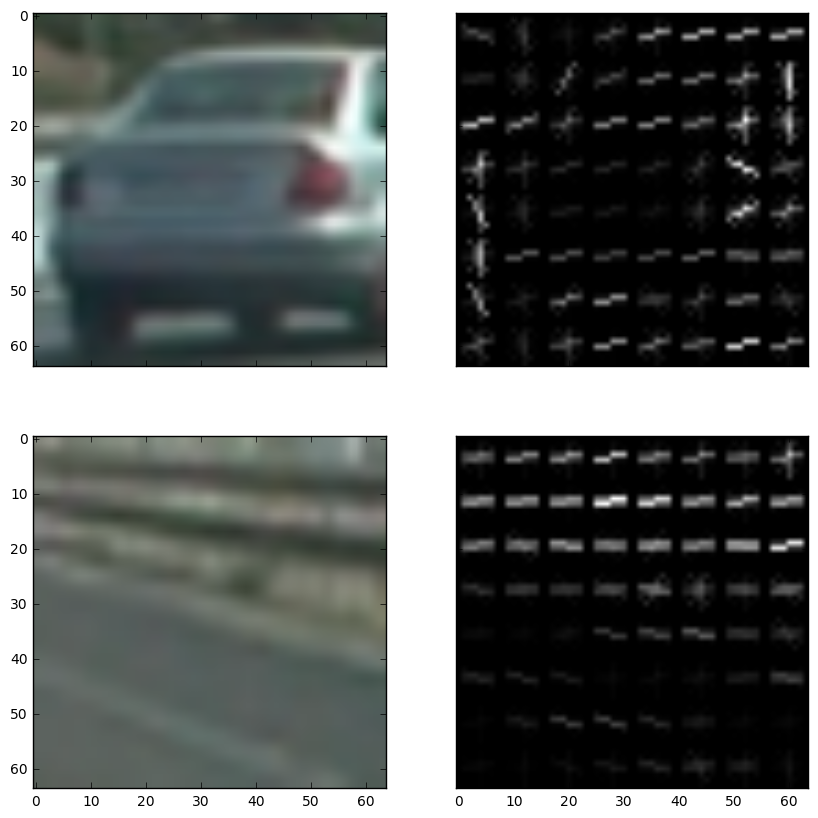

In [1]:
import Routines as ro
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

car = mpimg.imread('output_images/image0009.png')
noncar = mpimg.imread('output_images/image100.png')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=[10, 10])
_, hog_car = ro.get_hog_features(car[:,:,1], 9, 8, 2, vis=True, feature_vec=True)
_, hog_noncar = ro.get_hog_features(noncar[:,:,1], 9, 8, 2, vis=True, feature_vec=True)

ax1.imshow(car)
ax2.imshow(hog_car, cmap='gray')
ax3.imshow(noncar)
ax4.imshow(hog_noncar, cmap='gray')

I have employed an exhaustive grid search to come up with the following:
* 'color_space'= 'YCrCb'
* 'orient'= 9
* 'pix_per_cell' =  8
* 'cell_per_block' = 2
* 'hog_channel'= "ALL"
* 'spatial_size' = (32, 32)
* 'spatial_feat' =  True
* 'hist_feat' =  False
* 'hog_feat' = True

where the three boolean values indicate whether to include the particular feature. The rest of the feature names are self explanatory.

The grid search is performed in the function "param_search" under "detect.py". The goal of the search is to train a linear SVM classifier with all combination of parameters defined in the dictionary "param_grid" and pick the combination that maximizes the accuracy on the test dataset. (details later)

## 2. Classifier

A feature set comprising of the "HOG" and the "Spatial" features was constructed for every car and non-car image. The 
features were then scaled to have zero mean and unit variance. A linear SVM model was trained on randomly chosen 80% 
of the data and an accuracy score of 99% was obtained for the best selection of features. The corresponding code is
available under the "create_model" function in "detect.py". 

In [2]:
from detect import train_model
clf, scaler, params = train_model('regular')

number of cars =  8792
number of non-cars =  9666
image size for cars:  (64, 64, 3)
image size for non-cars:  (64, 64, 3)
31.34 Seconds to train SVC...
Test Accuracy of SVC =  0.9884
Accuracy =  0.9884
__________________________________________


## 3. Sliding Window Search

The sliding window search is implemented in the function "search_windows" under "Routines.py". I started with a 
few classifiers with high accuary but trained with different combination of parameters and applied the sliding 
window technique with each one of those on a few different images. I used a few different window sizes and a few
different overlap values between the windows and visually picked the window parameters that picked up most of the 
cars and produced the least amount of false positives.

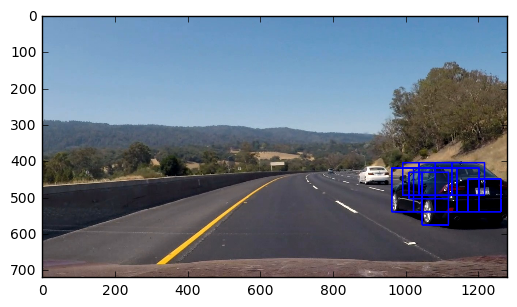

In [3]:
from detect import plot_bounding_box
image = mpimg.imread("output_images/frame740.jpg")
_ = plot_bounding_box(image, clf, scaler, params, plot_box=True)

In the final implementation, the lower half of the frame is searched starting from imy/10 to imy/6 in 5 steps, where 
imy is the y-dimension of the image. A 50% overlap in both x and y direction was chosen between adjacent windows.

## 4. Video Implementation

I tried to improve the classifier by doing an exhaustive grid search followed by window search parameters to improve
car detection. The final choice of parameters introduced quite a bit of false positives. To remove those, an average
of heatmaps over successive frames was calculated followed by an application of threshold to remove hot areas in the
image that don't persist. The final version of the pipeline used an average over 6 consecutive frames and a threshold
value of 3.

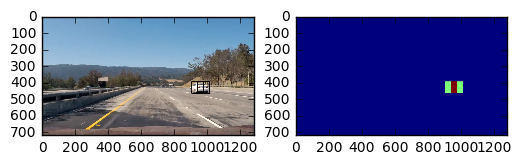

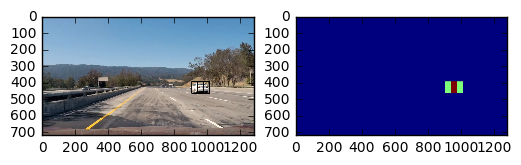

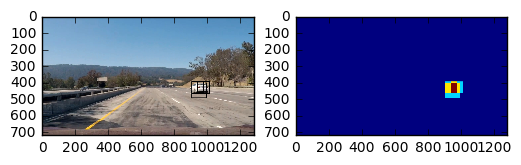

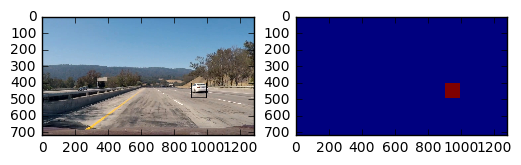

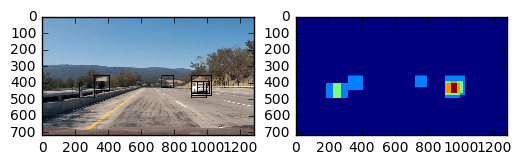

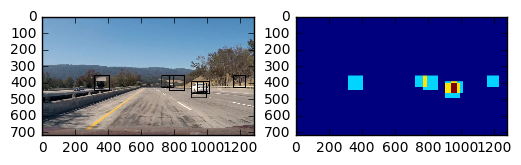

In [4]:
from detect import get_frame_aggregate
from scipy.ndimage.measurements import label
from queue import Queue
import glob
import numpy as np

heatmap_threshold = 4
files = glob.glob("output_images/frame5*.jpg")
frames = Queue()
for file in files:
    image = mpimg.imread(file)
    image = image.astype(np.float32)/255
    image = plot_bounding_box(image, clf, scaler, params, plot_box=True, plot_heat=True)
    frames.put(image)

agg_frame, _ = get_frame_aggregate(frames)
agg_frame[agg_frame <= heatmap_threshold] = 0
labels = label(agg_frame)
draw_img = ro.draw_labeled_bboxes(mpimg.imread(files[-1]), labels)

The final image with the bounding box after removing false positive looks like this:

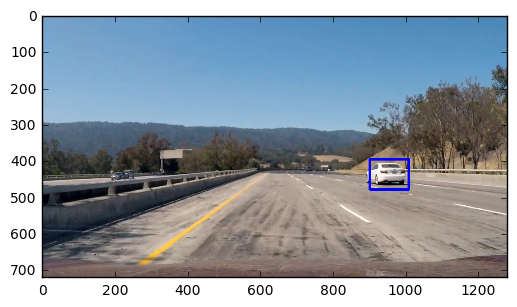

In [5]:
plt.imshow(draw_img)

The final annotated video is "project_video_annotated.mp4".

## 5. Discussions

One of the major challenge in the project was the quality of the training images. They were quite blurry, whereas the
actual video images were clear. I believe training with clearer pictures would have performed better on the final video.

Another challenge was to detect cars farther away when there is a prominent car in the foreground. My pipeline does not
do well under this condition. Training a model consisting of multiple cars in the same frame with bounding boxes would
very likely improve the performance of the pipeline. I am aware of the existence of this data but did not have enough 
time to create the necessary pipeline. 